In [116]:
%matplotlib inline
import cv2 #　opencvのインポート
import matplotlib
import matplotlib.pyplot as plt # matplotlib(描画用)
import numpy as np
import math, time
from scipy.cluster.hierarchy import linkage,dendrogram, fcluster

print('opencv version: ' + cv2.__version__)
print('matplotlib version: ' + matplotlib.__version__)
print('numpy version: ' + np.__version__)

opencv version: 4.1.2
matplotlib version: 3.2.2
numpy version: 1.18.5


In [128]:
# このセルはGoogle Colaboratory使用時のみ必要
from google.colab import files
f = files.upload() # ファイルアップロード

Saving flowers_mini2.jpg to flowers_mini2.jpg
Saving wagashi_part_small3.png to wagashi_part_small3 (8).png


> 9.2. Implement a mean shift segmenter.

以下, 自作したmean shiftによるセグメンタの実装を示す.

なお, 以下サイトを参考にした.  

- Mean Shift Clusteringについて  
http://takashiijiri.com/study/ImgProc/MeanShift.htm

- Mean Shift Filteringの収束値  
https://www.orfeo-toolbox.org/CookBook/Applications/app_MeanShiftSmoothing.html

In [118]:
## Utilities
# パスから画像をRGBで取得
def GetImage(file_path, cv_option=cv2.COLOR_BGR2RGB, is_show=False):
  img = cv2.imread(file_path)
  img = cv2.cvtColor(img, cv_option)

  if is_show:
    plt.title('Acquired Image'), plt.xticks([]), plt.yticks([])
    plt.imshow(img)

  return img

# オリジナル画像を表示
def ShowOriginal(file_path):
  GetImage(file_path)
  plt.title('Original Image'), plt.xticks([]), plt.yticks([])
  plt.imshow(img)

def ConvertRGB2LUV(img):
  img = img / 255.  # from 0 to 1
  img = img.astype(np.float32)
  # img = cp.asarray(img)
  return cv2.cvtColor(img, cv2.COLOR_RGB2Luv)

In [119]:
## Mean shift filtering

def normal(x):
  return math.exp(-1/2. * x)
def diff_normal(x):
  return -1/2. * math.exp(-1/2. * x)

def epanechnikov(x):
  return 0 if x > 1 else 1 - x
def diff_spanechnikov(x):
  return 0 if x > 1 else -1

def uniform(x):
  return 0 if x < 0 or x > 1 else 1
def diff_uniform(x):
  return 0

# 画素位置(xi, yi)と画素値(Li, ui, vi)の結合ベクトルを取得
def GetBilateralVector(img):
  return [[np.array([y, x], dtype=np.float64), img[y, x]] for y in range(img.shape[0]) for x in range(img.shape[1])]

# 今回はプロファイルをガウシアンを用いたものに固定
k = normal
g = diff_normal

# Mean shiftを計算する
def CalcNextMeanShift(x, y, h_params):
  # 更新値 y(j+1) = Σα(i)x(i) / Σα(i) を計算する
  # αs(i) = g(i, hs) * k(i, hr), αr(i) = g(i, hr) * k(i, hs)

  ys_next = CalcMeanWeightedSum(x, 0, y, h_params)
  yr_next = CalcMeanWeightedSum(x, 1, y, h_params)
  return ys_next, yr_next

def CalcMeanWeightedSum(x, d, y, h_params): # d: 0 -> space, 1 -> color
  length_x = len(x)
  not_d = 0 if d == 1 else 1
  h_main_sq = h_params[d] ** 2
  h_sub_sq = h_params[not_d] ** 2
  y_main = y[d]
  y_sub = y[not_d]

  # 分母成分
  denom = np.array([g(sum((y_main-x[i][d]) ** 2) / h_main_sq) *\
                    k(sum((y_sub-x[i][not_d]) ** 2) / h_sub_sq)
                    for i in range(length_x)])
  # 分子成分
  numer = np.array([denom[i] * x[i][d] for i in range(length_x)])

  return np.sum(numer, axis=0) / np.sum(denom)

def ExcecuteMeanShiftFiltering(img, hs, hr, eps=1e-1):
  luv_img = ConvertRGB2LUV(img)
  x = GetBilateralVector(luv_img)
  img_h, img_w, _ = img.shape
  n = img_h * img_w
  result = []

  start = time.time()

  for i in range(0, n):
    ds = math.inf
    dr = math.inf
    y = x[i]

    # Mean shift procedure
    while ds > eps or dr > eps:
      ys_next, yr_next = CalcNextMeanShift(x, y, [hs, hr])  # update y
      ds = np.linalg.norm(y[0] - ys_next)
      dr = np.linalg.norm(y[1] - yr_next)
      y = [ys_next, yr_next]
      # print('ds: ' + str(ds) + ' dr: ' + str(dr))

    result.append(y)

    # 10画素ごとに進捗状況を表示
    if i % 10 == 0:
      print(i)

  elapsed_time = time.time() - start
  print ("normal elapsed_time:{0}".format(elapsed_time) + "[sec]")
  
  return result


In [120]:
# Mean shiftの結果から平滑化画像として出力
def ShowSmoothed(res, img_shape):
  filtered = np.empty(img_shape, dtype=np.float32)

  # ここは速度気にしてません
  for i in range(img_shape[0]):
    for j in range(img_shape[1]):
      filtered[i, j] = res[i * img_shape[0] + j][1]

  out_rgb2 = cv2.cvtColor(filtered, cv2.COLOR_Luv2RGB)
  plt.imshow(out_rgb2)

In [121]:
# Mean shiftの結果からセグメンテーションを行う
def ExcecuteSegmentation(res, hs, hr, img_shape, m=4, show_dendro=False):
  # hsとhrについて階層クラスタリングによるセグメンテーションを行い, 
  # 双方のラベル付けが異なるセグメントがあればその部分は新たにラベル付けする

  # 階層クラスタリング
  data_s = np.array([res[i][0] for i in range(len(res))])
  Zs = linkage(data_s, 'ward')
  data_r = np.array([res[i][1] for i in range(len(res))])
  Zr = linkage(data_r, 'ward')

  # クラスタリング結果からセグメンテーション
  cs = fcluster(Zs, hs, criterion='distance')
  cr = fcluster(Zr, hr, criterion='distance')

  # 新たなラベル付けを行う
  # まずタプルでラベル付けし, その後各組に新しく整数のラベルを振る
  c = [(cs[i], cr[i]) for i in range(len(res))]
  labels = np.array(range(len(set(c)))) + 1
  label_dict = dict(zip(set(c), labels)) # タプルと整数ラベルを対応付け
  c = [label_dict[c[i]] for i in range(len(res))]

  segmented =  np.array(c).reshape(img_shape)

  # セグメンテーション結果表示
  plt.title('Result of segmentation using mean shift filtering'), plt.xticks([]), plt.yticks([])
  plt.imshow(segmented)
  print('the number of clusters: ' + str(len(labels)))

以下, 次の順序で実行した様子を示す  
- 画像読み込み
- Mean Shift Filteringの実行
- Filtering実行結果からフィルター画像を表示
- Filtering実行結果からセグメンテーションを実行し画像を表示

(22, 22, 3)


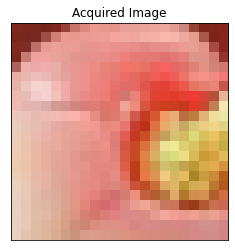

In [122]:
# 画像の読み込み
path = 'wagashi_part_small3.png'
img = GetImage(path, is_show=True)
print(img.shape)

In [123]:
# Mean Shift Filteringの実行
hs = 8
hr = 8
y = ExcecuteMeanShiftFiltering(img, hs, hr)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
normal elapsed_time:111.54399847984314[sec]


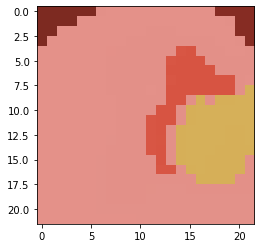

In [124]:
# Mean shiftの結果から平滑化画像として出力
ShowSmoothed(y, img.shape)

the number of clusters: 5


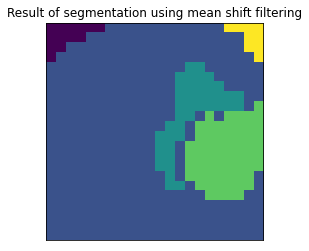

In [125]:
# セグメンテーションを実行し結果を表示
ExcecuteSegmentation(y, hs, hr, img.shape[:2], show_dendro=True)

もう一つの例

(27, 27, 3)


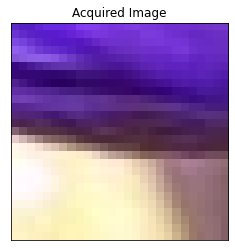

In [129]:
# 画像の読み込み
path = 'flowers_mini2.jpg'
img = GetImage(path, is_show=True)
print(img.shape)

In [131]:
# Mean Shift Filteringの実行
hs = 8
hr = 8
y = ExcecuteMeanShiftFiltering(img, hs, hr)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
normal elapsed_time:177.68622469902039[sec]


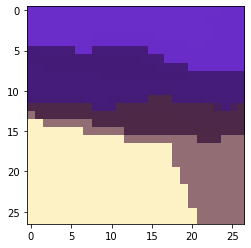

In [132]:
# Mean shiftの結果から平滑化画像として出力
ShowSmoothed(y, img.shape)

the number of clusters: 6


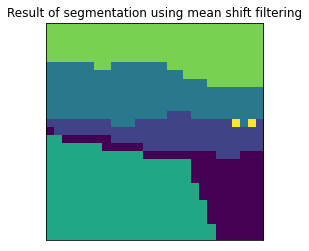

In [133]:
# セグメンテーションを実行し結果を表示
ExcecuteSegmentation(y, hs, hr, img.shape[:2], show_dendro=True)